# ESPIn Team Project - Channel Evolution ~ f(Water)
**Ekta Aggarwal$^1$, Leia Barnes$^2$, Morgan Carrington$^3$, Prakash Pokhrel$^4$, Caroline Mierzejewski$^5$**

[1] Univeristy of Southampton, UK, [2] Lehigh University, Bethlehem, PA, USA, [3] University of Texas at Austin, USA, [4] University of Glasgow, UK, [5] Texas State University, San Marcos, TX USA

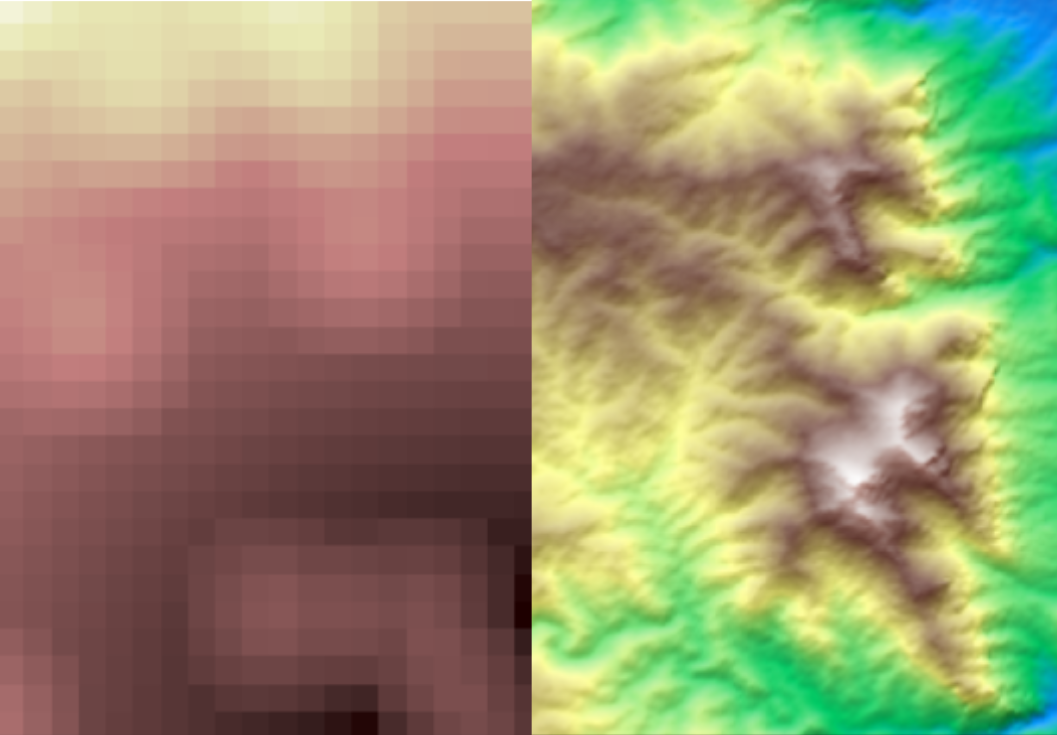

## Introduction
Precipitation aids in eroding landscapes creating new channels and causing others to migrate across floodplains. When discharge increases in the channel, due to frequent rainfall events, sediment transport will increase until the flow velocity decreases, changing the evolution of the channels.

By default, Landlab directs flow and accumulates it using FlowDirectors and FlowAccumulator. The downside to the above components is that they rely on the shallow water equation, something important to note when dealing with large precipitation events that lead to flooding. This project shows how overtime the intensity and frequency of rain events can cause incision and lateral changes in stream channels. This was completed using the following components: FastscapeEroder, PriorityFloodFlowRouter, ChannelProfiler, and SpatialPrecipitationDistribution.

Our goals are to 1) understand the LandLab component PriorityFloodFlowRouter to simulate flooding over a short period 2) initialise the random topography grid and 3) incorporate sediment erosion and deposition.

"The PriorityFloodFlowRouter component combines filling, flow direction and accumulation of water over structured grids in one component and significantly improves performances of flow accumulation and direction operations over large grids, especially when filling operations are required to route water over landscapes" (Barnes, R., 2017).


# Part 1: PriorityFloodFlowRouter & Lateral Channel Migration

This section of the notebook will walk you through an example of how LandLab components PriorityFloodFlowRouter and LateralEroder can be paired to investigate lateral channel migration in a landscape.

First and foremost, make sure to import the necessary packages. Note the annotations next to each of the packages  that explain what they will be used for!

In [1]:
import matplotlib.pyplot as plt                    # common package for plotting
import numpy as np                                 # common package for pretty much everything
from landlab import RasterModelGrid                # package needed to make the grid on which the LandLab components will run
from bmi_topography import Topography              # how we will get the DEM for the exercise
from landlab.io import read_esri_ascii             # will be used to read the DEM into a RasterModelGrid
from landlab import RasterModelGrid, imshow_grid, imshowhs_grid # how we will display the various outputs from the model
from landlab.components import PriorityFloodFlowRouter # LandLab component #1 that we will use; flow component
from landlab.components import FlowAccumulator, LateralEroder # LandLab component #2 that we will use; lateral erosion component

from matplotlib.colors import SymLogNorm           # will help us make the plot scales in a symmetrical log scale

## Download the DEM from OpenTopography

Here we will use the bmi-topography package to import a DEM. This package and Python library will be used to access and import the NASA Shuttle Radar Topography Mission (SRTM) land elevation data, which we will use to run our model! For more information on this package and how to use it yourself follow these links: [bmi-topography repo](https://github.com/csdms/bmi-topography) and [notebook on bmi-topography](https://github.com/csdms/bmi-topography/blob/main/examples/topography.ipynb).

We will start by defining the variable topo, which will create an instance of topography, and we will define the following parameters:

1. the type of data we are requesting - in this case SRTMGL1 (SRTM Global Dataset 1, resolution ~30 m)
2. the geographic bounding (south, north, west, east) of the data
3. the file format we want - in this case we want as an ascii file
4. where to store the file

In [2]:
topo = Topography(
    dem_type="SRTMGL1",
    south=39.93,
    north=40.0,
    west=-105.33,
    east=-105.26,
    output_format="AAIGrid",
    cache_dir="DEMData//",
)

Simply just creating the topo variable and creating an instance of topography does not download the data. We will also need to use `fetch` to download the data and `load` to commit the data to memory.

In [24]:
fname = topo.fetch(
)
print(fname)

/home/jupyter-lgb224@lehigh.edu/ivy/lessons/landlab/landlab/DEMData/SRTMGL1_39.93_-105.33_40.0_-105.26.asc


In [25]:
dem = topo.load()
print(dem)

<xarray.DataArray 'SRTMGL1' (band: 1, y: 252, x: 252)> Size: 254kB
[63504 values with dtype=int32]
Coordinates:
  * band         (band) int64 8B 1
  * x            (x) float64 2kB -105.3 -105.3 -105.3 ... -105.3 -105.3 -105.3
  * y            (y) float64 2kB 40.0 40.0 40.0 40.0 ... 39.93 39.93 39.93 39.93
    spatial_ref  int64 8B 0
Attributes:
    _FillValue:    -32768
    scale_factor:  1.0
    add_offset:    0.0
    units:         unknown


/opt/tljh/user/envs/csdms/lib/python3.12/site-packages/bmi_topography/topography.py:183: UserWarning: A CRS cannot be identified for these data. Grid units will be set to 'unknown'.
  warnings.warn(


We can now look at the downloaded data using `read_esri_ascii` and `imshow`!

/tmp/ipykernel_948178/1741896219.py:1: DeprecationWarning: landlab.io.read_asc_header has been deprecated, use landlab.io.esri_ascii.parse instead
  grid_geog, elev = read_esri_ascii(fname, name="topographic__elevation") # reading in the data, calling the grid object grid_geog and assigning topo to elev variable


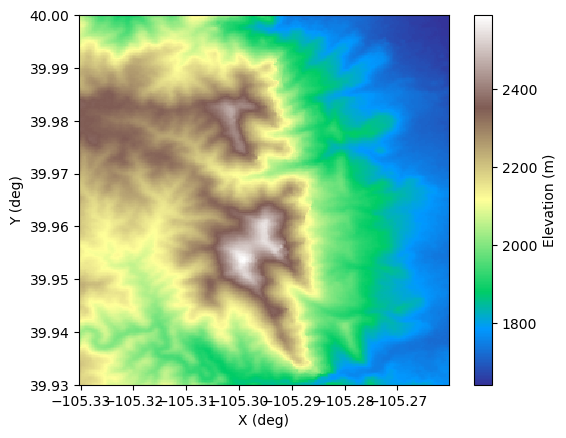

In [4]:
grid_geog, elev = read_esri_ascii(fname, name="topographic__elevation") # reading in the data, calling the grid object grid_geog and assigning topo to elev variable

grid_geog.imshow( # visualizing the topo elevation using imshow!
    "topographic__elevation", 
    cmap="terrain",
    grid_units=("deg", "deg"),
    colorbar_label="Elevation (m)",
)

We're looking at a portion of the Flat Irons!

Looking at this visualization, you will notice that the X and Y axis are in degrees. This is telling us that the DEM is currently in a geographic coordinate system. We actually want the DEM, and soon to be raster model grid, to be in a projected coordinate system for what we want to do.

The code below will do all of this in one step, converting the DEM into a projected coordinate system *AND* reading it in as a LandLab grid object (`RasterModelGrid`) with spacing of 30 meters (the resolution of the STRM data). We will also define the topographic elevation to be recorded at the nodes.

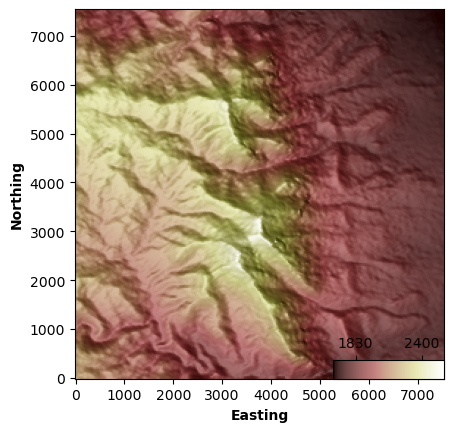

In [5]:
# make a new grid with RasterModelGrid, use the dimensions of grid_geog
grid = RasterModelGrid(grid_geog.shape, xy_spacing=30.0)
grid.at_node["topographic__elevation"] = grid_geog.at_node["topographic__elevation"]

imshowhs_grid(grid, "topographic__elevation"); # let's visualize this new LandLab grid object! 

As you can see from the imshow plot above, the DEM has now been projected and used to initialize a LandLab grid object.

## Run the LandLab Components

With the LandLab grid now initialized, we can now begin to run the components: PriorityFloodFlowRouter and LateralEroder.

We will first start by instantiating the PriorityFloodFlowRouter, which fills/breaches depressions, accumulates flow, and calculates draiange area for a given LandLab grid object. More information about this component can be found here: [PriorityFloodFlowRouter Documentation](https://landlab.csdms.io/generated/api/landlab.components.priority_flood_flow_router.priority_flood_flow_router.html#landlab.components.priority_flood_flow_router.priority_flood_flow_router.PriorityFloodFlowRouter).

In [6]:
flow_metric = 'D8' # the flow algorithm to be used to calculate flow direction and flow accumulation
flow_acc_PF = PriorityFloodFlowRouter(grid, surface = 'topographic__elevation', flow_metric = flow_metric,
                                suppress_out = True, depression_handler = 'fill', accumulate_flow = True,
                                separate_hill_flow = True, accumulate_flow_hill = True) # instantiating the component here!

flow_acc_PF.run_one_step() # need to run the component one step in order to calculate the flow direction and accumulation

We can visualize the DEM aside the PriorityFloodFlowRouter drainage area calculation for our LandLab grid here using this incredible function writen by Dr. Susannah Morey!

In [9]:
def plotting(
    grid, 
    topo=True, # making a plot for elevation are plotting/visualization
    DA=True,  # making a plot for the calculated drianage area
    flow_metric="D8", # the flow routing algorithm again
):
    if topo: # a bunch of specifications to make the plots nice
        azdeg = 200
        altdeg = 20
        ve = 1
        plt.figure()
        plot_type = "DEM"
        ax = imshowhs_grid(
            grid,
            "topographic__elevation",
            grid_units=("deg", "deg"),
            var_name="Topo, m",
            cmap="terrain",
            plot_type=plot_type,
            vertical_exa=ve,
            azdeg=azdeg,
            altdeg=altdeg,
            default_fontsize=12,
            cbar_tick_size=10,
            cbar_width="100%",
            cbar_or="vertical",
            bbox_to_anchor=[1.03, 0.3, 0.075, 14],
            colorbar_label_y=-15,
            colorbar_label_x=0.5,
            ticks_km=False,
        )
    if DA: # some more specifications to make the drainage area plot nice
        # %% Plot first instance of drainage_area
        grid.at_node["drainage_area"][grid.at_node["drainage_area"] == 0] = (
            grid.dx * grid.dx
        )
        plot_DA = np.log10(grid.at_node["drainage_area"] * 111e3 * 111e3)

        plt.figure()
        plot_type = "Drape1"
        drape1 = plot_DA
        thres_drape1 = None
        alpha = 0.5
        ax = imshowhs_grid(
            grid,
            "topographic__elevation",
            grid_units=("deg", "deg"),
            cmap="terrain",
            plot_type=plot_type,
            drape1=drape1,
            vertical_exa=ve,
            azdeg=azdeg,
            altdeg=altdeg,
            thres_drape1=thres_drape1,
            alpha=alpha,
            default_fontsize=12,
            cbar_tick_size=10,
            var_name="$log^{10}DA, m^2$",
            cbar_width="100%",
            cbar_or="vertical",
            bbox_to_anchor=[1.03, 0.3, 0.075, 14],
            colorbar_label_y=+5,
            colorbar_label_x=0.5,
            ticks_km=False,
        )

        props = dict(boxstyle="round", facecolor="white", alpha=0.6)
        textstr = flow_metric # adding flow metric label to the plot, could change this or add more plots for other algorithms!
        ax.text(
            0.05,
            0.95,
            textstr,
            transform=ax.transAxes,
            fontsize=10,
            verticalalignment="top",
            bbox=props,
        )

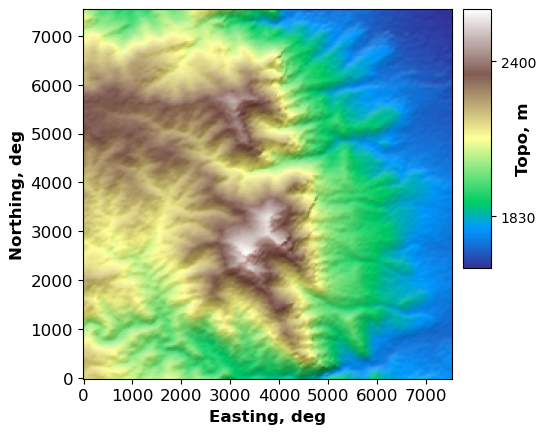

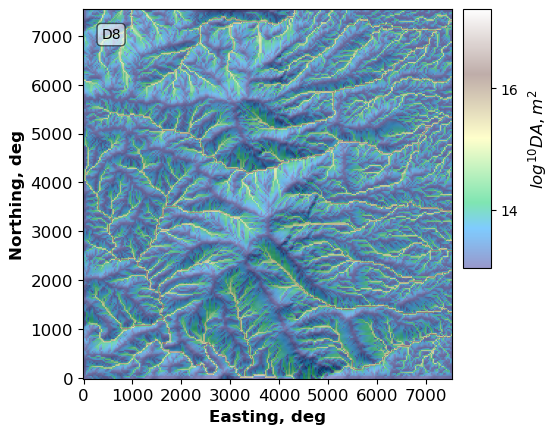

In [10]:
# Visualizing the elevation data and the drainage area calculations using the pretty code above :)
plotting(grid, DA=True)

We will next initialize the LateralEroder component which, when paired with the PriorityFloodFlowRouter, will model how fluvial erosion drives lateral channel migration.

Start first by intializing the grid nodes to record `volume__lateral_erosion`, which save arrays of lateral erosion in measurements of volume ($L^3$). Then run the component once in order to set us up for the next step o f the model.

In [11]:
# defining some necessary variables
U = 0.001 # uplift rate
dt = 100 # model time step

grid.add_zeros('volume__lateral_erosion', at = 'node') # initializing the lateral erosion volumes at the grid nodes

lateral = LateralEroder(grid, latero_mech = 'UC', Kv = 0.001, Kl_ratio = 1.5) # instantiating the LateralEroder
grid, dzlat = lateral.run_one_step(dt) # running component here, need both the grid object AND the change in lateral space variable

With both the PriorityFloodFlowRouter and the LateralEroder all instantiated and ran for one time step, we can now evolve the landscape!

The while loop below is designed to run the components until all channels in the landscape grid have some non-zero measure of lateral change from their initial condition. As a fun exercise, try writing this same code as a for loop (that is possible!).

In [12]:
while min(dzlat) == 0.0: # saying that this code will run until there is lateral change in every node possible
    oldlatvol = grid.at_node["volume__lateral_erosion"].copy() # make copies of the old lateral volume erosion arrays
    oldelev = grid.at_node["topographic__elevation"].copy() # copies the elevation arrays 
    flow_acc_PF.run_one_step() # runs the flow accumulator one more step as the landscape evolves (uplift, erosion, etc.)
    grid, dzlat = lateral.run_one_step(dt) # runs the lateral eroder for another dt-defined time step
    newlatvol = grid.at_node["volume__lateral_erosion"] # records new lateral volume erosion at the nodes
    newelev = grid.at_node["topographic__elevation"] # records new topo elevation at the nodes
    grid.at_node["topographic__elevation"][grid.core_nodes] += U * dt # uplift the surface at the core nodes!

## Visualize the Results

Now, let's visualize some of the results from the model we ran above! We will use `plt.imshow` to show the various output variables. 

First looking at volume of laterally eroded material.

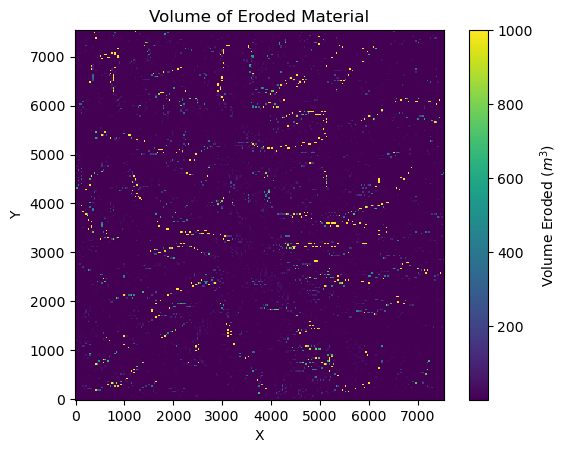

In [13]:
grid.imshow("volume__lateral_erosion", # calling on the values to be plotted
            plot_name="Volume of Eroded Material", # naming the plot
            var_name="Volume Eroded ($m^3$)", # naming the color bar
            norm = SymLogNorm(linthresh=1, vmin=grid.at_node['volume__lateral_erosion'].max(), vmax=grid.at_node['volume__lateral_erosion'].max()),
            vmin = 0.1,
            vmax = 1000, # setting the max of the color bar
            cmap = 'viridis', # colormap
           )

Let's look at sediment fluxes for the channels in this landscape.

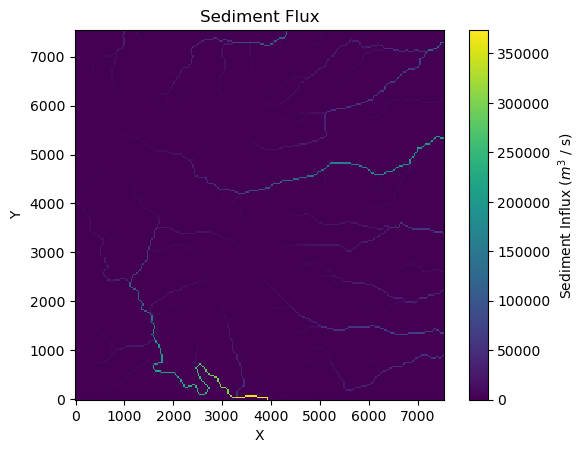

In [14]:
grid.imshow("sediment__influx", # defining the value of the node we want to look at
            plot_name="Sediment Flux", # naming the plot
            var_name="Sediment Influx ($m^3$ / s)",  # naming the color bar
            # vmin=0.1,
            # vmax=1000,
            norm='log',
            cmap = 'viridis', # another color map
           )

In this example, I only explore two possible outputs from the model. To see other examples of outputs that can be analyzed, use `output_var_names` as in the example below!

In [15]:
lateral.output_var_names

('lateral_erosion__depth_increment',
 'sediment__influx',
 'topographic__elevation',
 'volume__lateral_erosion')

# Part 2: Initial Setup 
We need to first install necessary python packages and create the synthetic grid/ landscape used to test the landlab components. 

## Importing Necessary Libraries and Components

In [16]:
# import packages

import numpy as np

import matplotlib as mpl
import matplotlib.pyplot as plt
import matplotlib.image as mpimg
from matplotlib import cm

from landlab import RasterModelGrid
from landlab.components import FastscapeEroder, PriorityFloodFlowRouter, ChannelProfiler,  SpatialPrecipitationDistribution 
from landlab.plot import imshow_grid
from landlab.plot.drainage_plot import drainage_plot
from landlab.io import esri_ascii

import copy
import os

## Define Plotting Functions and Generate a Grid

A raster model grid is initially created using rastermodelgrid showing a slanted bowl like landscape which we incorporated small hills scattered around the surface to create channels flowing from the top right corner to the bottom left. We chose to create a simplified synthetic landscape to easily show evolution of channels through time when affected by precipitation intensity and frequency.


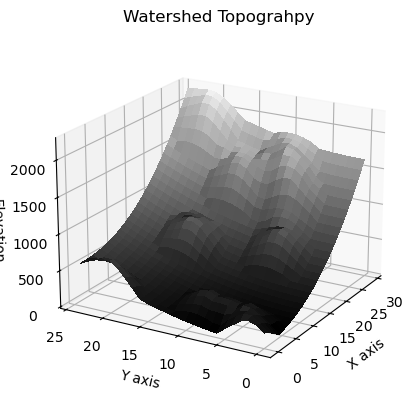

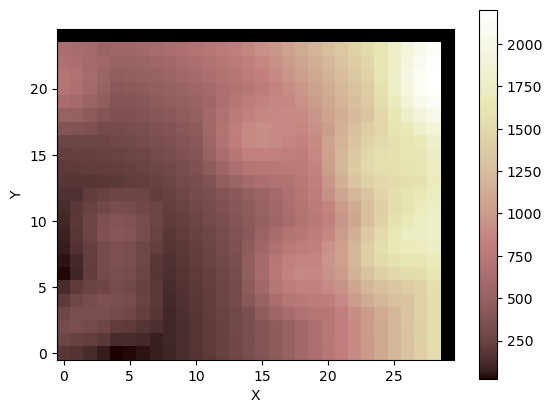

In [17]:
def surf_plot(mg, surface="topographic__elevation", title="Surface plot of topography"):
    plt.figure()
    ax = plt.axes(projection="3d")
    
    # Plot the surface.
    Z = mg.at_node[surface].reshape(mg.shape)
    color = cm.gray((Z - Z.min()) / (Z.max() - Z.min()))
    ax.plot_surface(
        mg.x_of_node.reshape(mg.shape),
        mg.y_of_node.reshape(mg.shape),
        Z,
        rstride=1,
        cstride=1,
        facecolors=color,
        linewidth=0.0,
        antialiased=False,
    )
    ax.view_init(elev=20, azim=-150)
    ax.set_xlabel("X axis")
    ax.set_ylabel("Y axis")
    ax.set_zlabel("Elevation")
    plt.title(title)
    plt.show()

# Create a raster model grid 

mg = RasterModelGrid((25, 30))
x, y = mg.x_of_node, mg.y_of_node
base_elevation =1.0 + x**2.2 + y**2
mg.add_field("topographic__elevation", base_elevation, at="node")

# Selecting nodes to generate hills on topographic slope

num_bumps = 10 #picks 10 random number of nodes that will be raised up
bump_height = 300 #raises the randomly selected nodes 300
bump_radius = 4  # choses radius around each raised node to also effect
sigma = bump_radius / 2.0

# raised_nodes = np.random.choice(mg.number_of_nodes, size=num_bumps, replace=False) # Use this code to initially choose a number of nodes to raise on the hillslope 
# print("Random node indices:", raised_nodes) # If you would like to see which nodes are affected from the previous line, print the nodes that are raised

raised_nodes = np.array([197, 124, 494, 443,  60, 233, 627, 296, 600, 274]) # This code selects 10 nodes to raise that were initially chosen at random

# Add a Gaussian bump around each raised node

for node in raised_nodes:
    xc, yc = x[node], y[node]
    distances = np.sqrt((x - xc)**2 + (y - yc)**2)
    mask = distances < bump_radius
    bump = bump_height * np.exp(-((distances[mask])**2) / (2 * sigma**2))
    mg.at_node["topographic__elevation"][mask] += bump

# Set boundary conditions, closing the top and right boundary and keeping the left and bottom open to allow for the channels to flow out
mg.status_at_node[mg.nodes_at_left_edge] = mg.BC_NODE_IS_FIXED_VALUE
mg.status_at_node[mg.nodes_at_top_edge] = mg.BC_NODE_IS_CLOSED
mg.status_at_node[mg.nodes_at_bottom_edge] = mg.BC_NODE_IS_FIXED_VALUE
mg.status_at_node[mg.nodes_at_right_edge] = mg.BC_NODE_IS_CLOSED

# Plot the final terrain

surf_plot(mg, title="Watershed Topograhpy") #creates a 3d version of the topographic elevation with elevation ranging from ~ 2,000 to 0 

mg.imshow("topographic__elevation") #creates a 2d version of the topographic elevation

## Initializing the Precipitation Event
The script simulates a rainstorm event over a spatial grid. It modifies the storm characteristics for visual appeal, plots the rainfall flux, saves it to a file, and then applies a random filtration factor to compute the final water flux. This code simulates only one storm, but you could loop it over multiple.

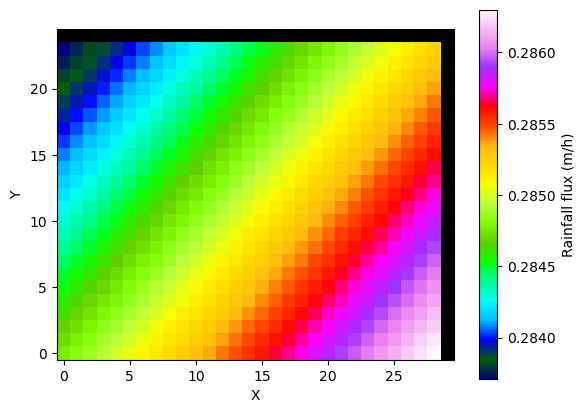

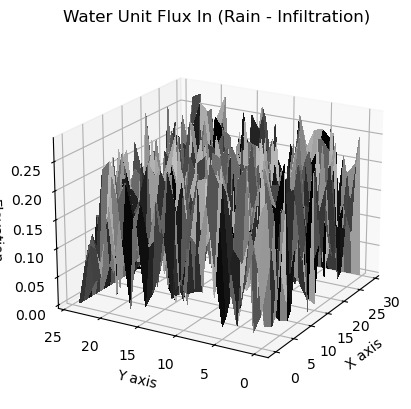

In [18]:
rain = SpatialPrecipitationDistribution(mg)# Creating an instance of the SpatialPrecipitationDistribution to simulate precipitation on the grid

np.random.seed(26)#Set a fixed random seed to make the simulation reproducible to get the same storm every time

# get the storm simulator to provide a storm
# There's only one storm generated here in the time series, so easy enough to do.
# Check if the directory to save rainfall data exists, if not, create it
if not os.path.exists("./rainfall"):
    os.makedirs("./rainfall")
    
# Generate storm and interstorm durations using a monsoonal rainfall pattern
# storm lengths in hrs
for storm_t, interstorm_t in rain.yield_storms(style="monsoonal"):# Convert rainfall units from mm/h to m/h by multiplying by 0.001
    mg.at_node["rainfall__flux"] *= 0.001  # because the rainfall comes out in mm/h
    # Make the storm more intense by for example multiplying rainfall by a factor of 20
    mg.at_node["rainfall__flux"] *= 20#10.0
    
  # Plot the rainfall flux across the grid
    plt.figure()
    mg.imshow("rainfall__flux", cmap="gist_ncar", colorbar_label="Rainfall flux (m/h)")
    plt.show()
    
    # Save the rainfall data in ESRI ASCII format for external use
    with open("./rainfall/rainfall.asc", "w") as fp:
        esri_ascii.dump(mg, fp, name="rainfall__flux", at="node")
 
 # Generate a random filtration coefficient (0 to 1) at each node to simulate loss due to infiltration
filtration = np.random.rand(mg.number_of_nodes)
# Calculate the final water flux into the system by applying filtration loss
final_flux_in = mg.at_node["rainfall__flux"] * (1 - filtration)

#Add the final flux field to the grid object and rewrite it if it already exists
_ = mg.add_field("water__unit_flux_in", final_flux_in, at="node", clobber=True)

surf_plot(mg, surface="water__unit_flux_in", title="Water Unit Flux In (Rain - Infiltration)")


# PriorityFloodFlowRouter


## Initialize Flow Router and Plot Discharge   

PriorityFloodFlowRouter is a component used to accumulate flow and calculate drainage area using the priorty flood algorithm. Perimeter nodes do not add to flux accumulation. The component merges a filling/breaching algorithm, a flow director as well as a flow accumulator.

This step used specified elevation field (mg) to direct flow across the grid using the D8 algorithm. The component automatically identify and handle depressions, and uses the water_unit_flux_in as the input for calculating the surface water discharge.

In [19]:
# set up parameters for the PriorityFloodFlowRouter

"""
Parameters: 
mg = raster model grid created above
surface = surface to direct flow across 
update_flow_depressions =  build-in depression handler
depresion_handler = breach or fill, breach creates drainage path on depression cell
"""

fa = PriorityFloodFlowRouter(
    mg, 
    surface="topographic__elevation",
    flow_metric="D8", #
    update_flow_depressions=True,
    depression_handler="breach", 
 )

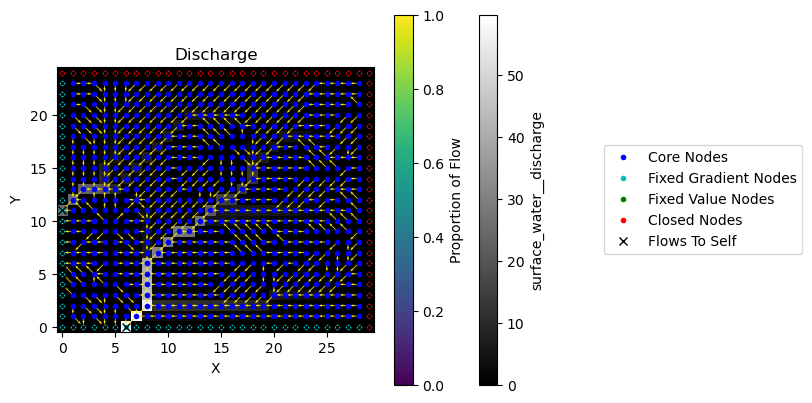

In [20]:
# run one step with PriorityFloodFlowRouter and create surface water discharge plot

fa.run_one_step()
plt.figure()
drainage_plot(mg, "surface_water__discharge", title="Discharge")

# Channel Evolution
In order to observe changes in channel morphology, we need to first plot the initial channel profiles. 

## Plot Initial Channel Profile

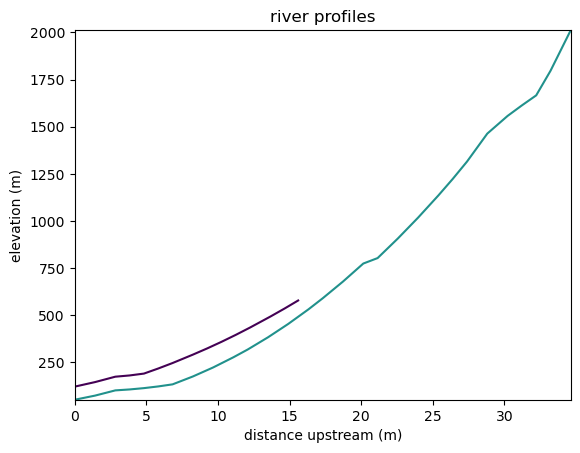

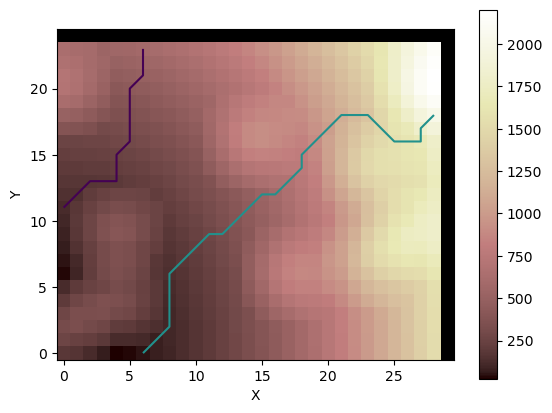

In [21]:
# set up parameters for channel profiler 

"""
Parameters: 
mg_1 = raster model grid 
channel_definition_field = name of the field used to identify outlet of headwater nodes 
number_of_watersheds = total number of watersheds to plot
main_channel_only = if True only plots the main channel, if False plots all stream segments with drainage area less than threshold should be plotted
"""

mg_1 =mg # raster model grid created above (mg)

cp_1 = ChannelProfiler(
mg_1,
channel_definition_field='drainage_area',
number_of_watersheds=2, # only wanting to see the two largest river channels across the landscape 

main_channel_only=True, # only wanting to plot the main river channel, but could easily plot the networks if “minimum_channel_threshold” was defined
)

# plot initial channel profiles 
cp_1.run_one_step()
plt.figure(1)  # plots initial figure of 2 largest channels of elevation against distance upstream
cp_1.plot_profiles(xlabel="distance upstream (m)", ylabel="elevation (m)", title='river profiles')

plt.figure(2) # plots initial figures in map view of 2 largest channels across the synthetic elevation 

cp_1.plot_profiles_in_map_view()
# Save the second figure
plt.savefig('river_profiles_plot_1.png', dpi=300, bbox_inches='tight')

## Incision
Next, we want to see how the landscape erodes over time with water, and for that we will need to use a stream power eroder component (FastscapeEroder). In order to see how the landscape changes, we need to run the model for an amount of time which can be altered for the desired output. 

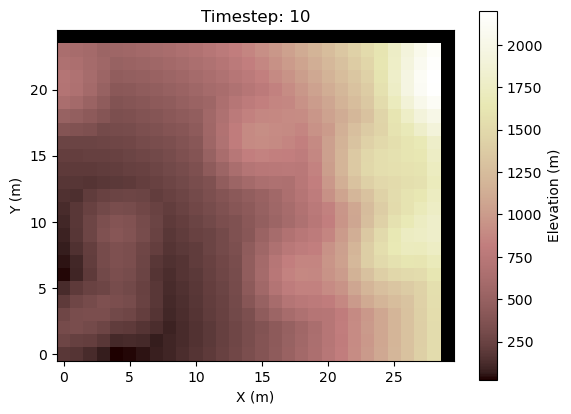

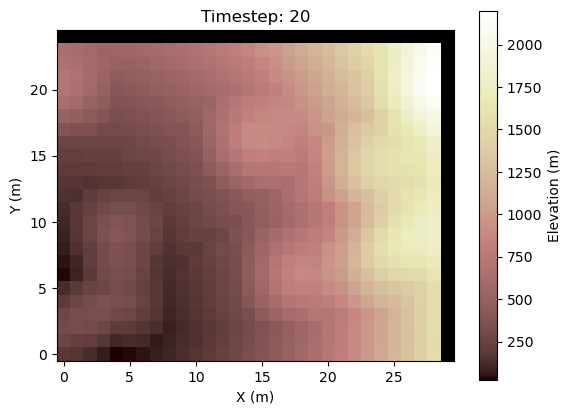

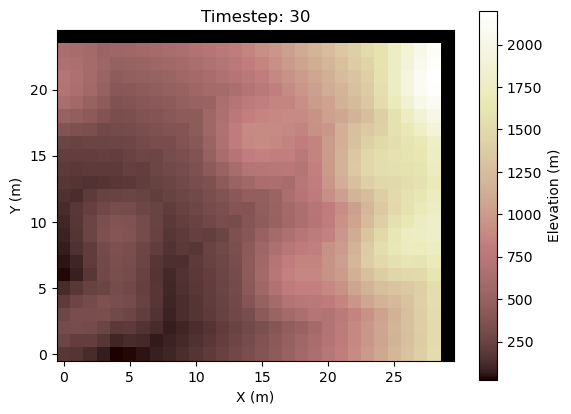

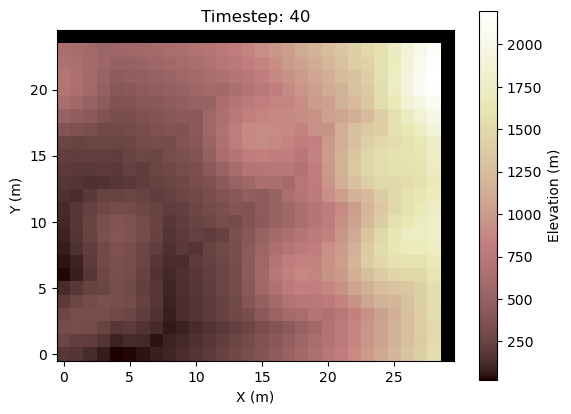

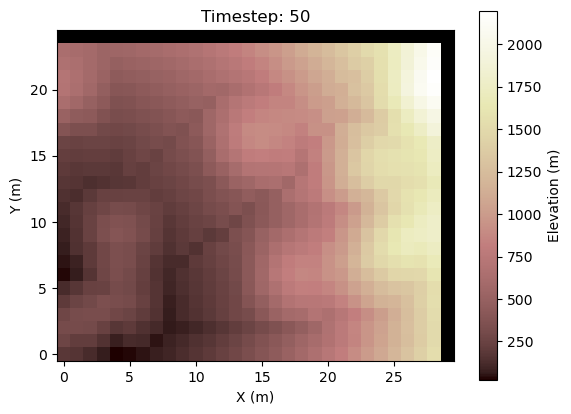

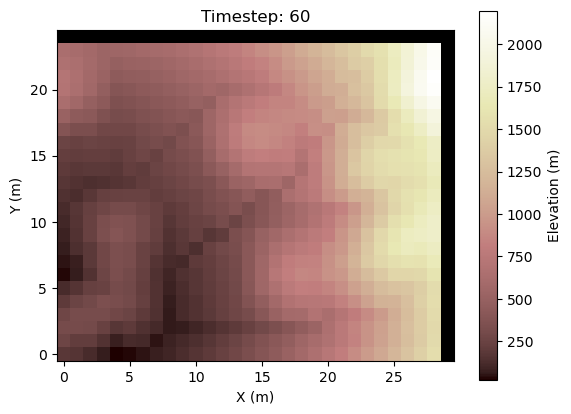

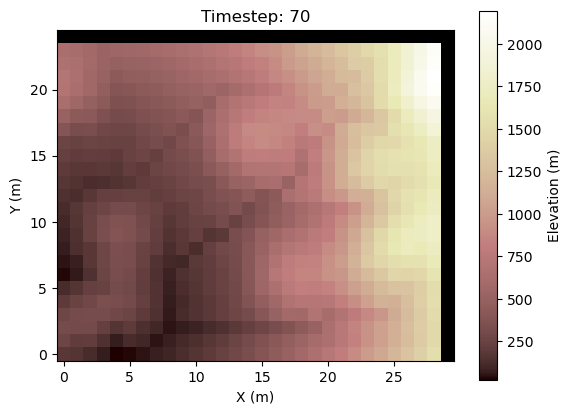

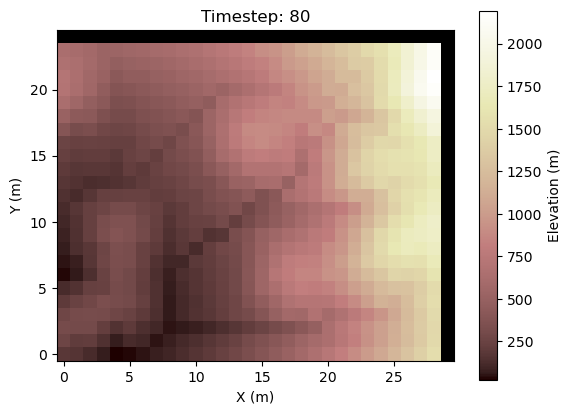

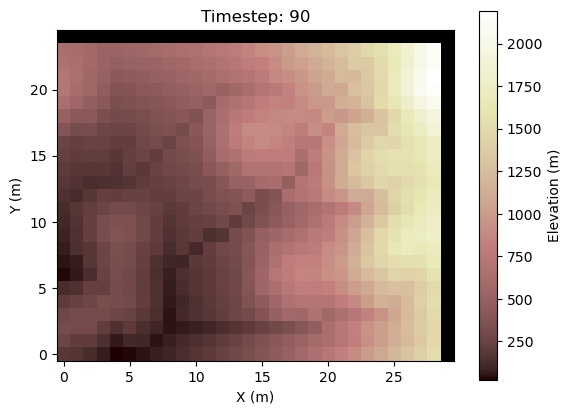

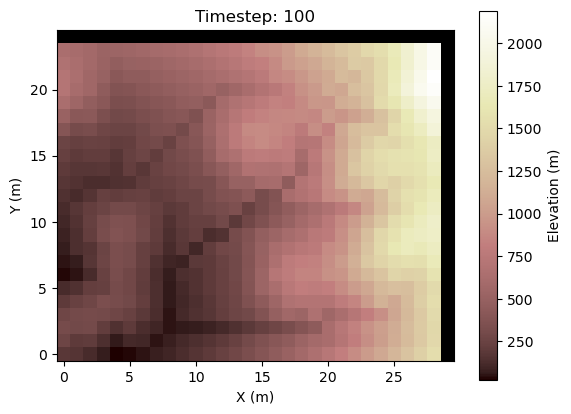

In [22]:
# stream power eroder component

"""
Fastscape Eroder Model Parameters: 
- mg: RasterModelGrid
- K_sp = constant that incorporates erodibility of rock efficiency of sed transport, and climate
- m_sp = exponent on drainage area
- n_sp = exponent on slope
- discharge_field = [L^2/T]. The default is to use the grid field 'drainage_area', use "surfacce_water__discharge" for keyword argument
"""

sp = FastscapeEroder(
    mg,
    K_sp=0.001, 
    m_sp=0.5,
    n_sp=1.0,
    discharge_field="surface_water__discharge",
)

# Run model for 1,000 years plotting every 100 years

run_duration = 1000.0  # duration of run, yr
dt = 10.0  # time-step duration, yr
plot_every = 100.0  # time interval for plotting, yr

# Derived parameters

nsteps = int(run_duration / dt)
next_plot = plot_every

# Set up colormap

cmap = copy.copy(mpl.colormaps["pink"])

for i in range(1, nsteps + 1):
    fa.run_one_step() # Priority Flood Flow Router
    sp.run_one_step(dt) # Fastscape Eroder
    
    if i * dt >= next_plot: # plot grids
        plt.figure()
        imshow_grid(
            mg,
            "topographic__elevation",
            grid_units=["m", "m"],
            var_name="Elevation (m)",
            cmap=cmap,
        )
        plt.title(f"Timestep: {i}")
        next_plot += plot_every

## Channel Profile Post Run 
After running the model for 1000 years, we want to see how the two main channels have changed over time. We will use the same ChannelProfiler component to later be able to compare the differences. 

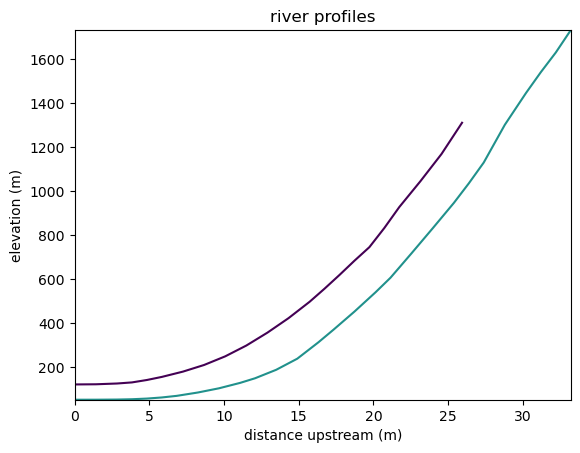

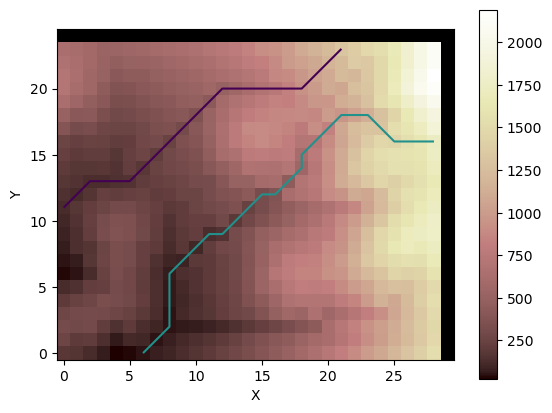

In [23]:
# set up parameters for channel profiler for profile after running model 
"""
Parameters: 
mg_1 = raster model grid 
channel_definition_field = name of the field used to identify outlet of headwater nodes 
number_of_watersheds = total number of watersheds to plot
main_channel_only = if True only plots the main channel, if False plots all stream segments with drainage area less than threshold should be plotted
"""

mg_2= mg # raster model grid created above (mg)
cp_2 = ChannelProfiler(
mg_2,
channel_definition_field='drainage_area',
number_of_watersheds=2, # only wanting to see the two largest river channels across the landscape that we initially had plotted
main_channel_only=True, # only wanting to plot the main river channel, but could easily plot the networks if “minimum_channel_threshold” was defined 
)

# plot final channel profiles 

cp_2.run_one_step()
plt.figure(1)  # plots final figure of 2 largest channels of elevation against distance upstream
cp_2.plot_profiles(xlabel="distance upstream (m)", ylabel="elevation (m)", title='river profiles')

plt.figure(2)  # plots final figure in map view of 2 largest channels across the synthetic elevation 

cp_2.plot_profiles_in_map_view()

# Save the second figure
plt.savefig('river_profiles_plot_2.png', dpi=300, bbox_inches='tight')

# Conclusion

This notebook was meant to introduce how LandLab can be used for landscape evolution in response to fluvial erosion, especially for audiences new to numerical modelling and/or landscape evolution (i.e., undergraduate students, LandLab crash course workshop, etc.). It covers a wide, but broad, example of how to achieve this in simulated or real landscapes and aims to show how one component can be investigated alone (lateral migration) or multiple can be incorporated to see combined effects (precipitation/rainfall, infiltration, incision).

Though we aim for simplicity in this specific case, these components, in addition to others not explored here, could be more thoroughly investigated in order to investigate a landscape’s response to tectonic, lithologic, and climatic perturbations. For example, tectonic and lithologic factors could be more rigorously explored by varying the erodibility coefficient or layering different rock types using the Lithology component.

All in all,
Landlab is an effective tool for modelling landscape evolution that can be driven by tectonic, lithology and climatic forces.
Without any prior background in numerical modeling, we are able to use Landlab to create a synthetic DEM and also work with real topographic data.
We found that Landlab is easy to use, even for users from diverse research backgrounds.


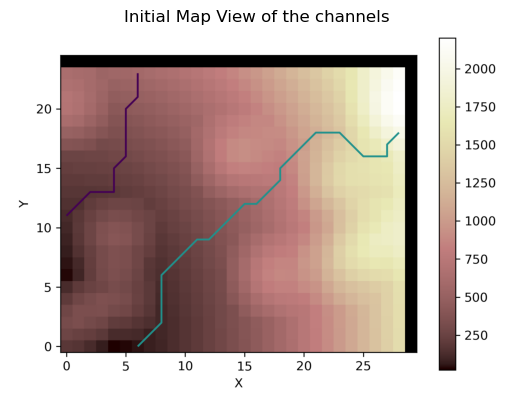

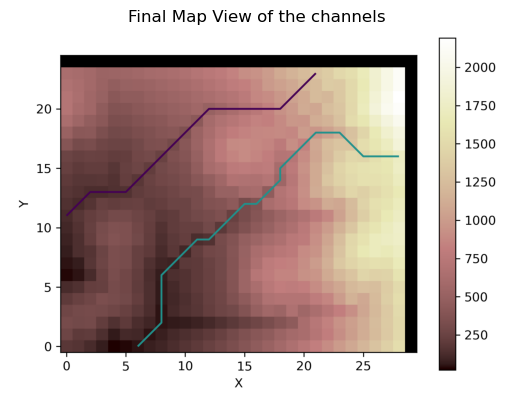

In [26]:
# First image
img1 = mpimg.imread('river_profiles_plot_1.png')
plt.figure()
plt.imshow(img1)
plt.axis('off')
plt.title('Initial Map View of the channels')

# Second image
img2 = mpimg.imread('river_profiles_plot_2.png')
plt.figure()
plt.imshow(img2)
plt.axis('off')
plt.title('Final Map View of the channels')

plt.show()


# References

Barnes, R., 2017. Parallel non-divergent flow accumulation for trillion cell digital elevation models on desktops or clusters. Environmental Modelling & Software 92, 202–212. doi: 10.1016/j.envsoft.2017.02.022

Campforts B., Shobe C.M., Steer P., Vanmaercke M., Lague D., Braun J. (2020) HyLands 1.0: a hybrid landscape evolution model to simulate the impact of landslides and landslide-derived sediment on landscape evolution. Geosci Model Dev: 13(9):3863–86.

Singer, M., Michaelides, K., Hobley, D. (2018). STORM 1.0: a simple, flexible, and parsimonious stochastic rainfall generator for simulating climate and climate change. Geoscientific Model Development 11(9), 3713-3726. https://dx.doi.org/10.5194/gmd-11-3713-2018
